In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Dirichlet Processes

We have seen with parametric mixture models that we can assign group labels to observations using a model, but so far we have assumed that we know how many groups there are *a priori*. What if we don't know how many groups produced the data? We often want the choice of $K$ to be **data-driven**.

There are a number of approaches for allocating samples to groups where the number of groups is not pre-determined. We will look at two generative methods here.

## The Bayesian Histogram

One way to approximate an unknown density using sample observations is using a *histogram*. One way to parametrically describe a histogram is by specifying a series of knots that define the bins of a histogram:

$$\zeta = \{\zeta_i: \zeta_1 \lt \zeta_2 \lt \ldots \lt \zeta_k \}_{h=1}^k$$

We can specify an associated probability model as:

$$f(x) = \sum_{h=i}^k I(\zeta_{h-1} \lt x \le \zeta_h) \frac{\pi_h}{\zeta_h - \zeta_{h-1}}$$

where $I$ is the indicator function and $\pi = \pi_1, \ldots, \pi_k$ a probability simplex.

We require a prior for the unknown probabilities, for which a natural choice is the *Dirichlet* distribution:

$$f(\mathbf{\pi}) = \frac{\prod \Gamma(\alpha_h)}{\Gamma(\sum_{h=1}^k \alpha_h)}\prod_{h=1}^{k} \pi_h^{\alpha_h - 1}$$

$$\text{where } \, E(\pi|\alpha) = \pi_0 = \frac{\alpha_1}{\sum_h \alpha_h}, \ldots , \frac{\alpha_k}{\sum_h \alpha_h}$$

Notice that the Dirichlet is just a generalization of the beta distribution to $k \gt 2$ classes.

It is easy to show that the resulting posterior distribution for $\pi$ is another Dirichlet:

$$\pi|x \sim \text{Dirichlet}(\alpha_1 + n_i, \ldots, \alpha_k + n_k)$$

where $n_h$ is the number of observations contained by the $h^{th}$ histogram bin.

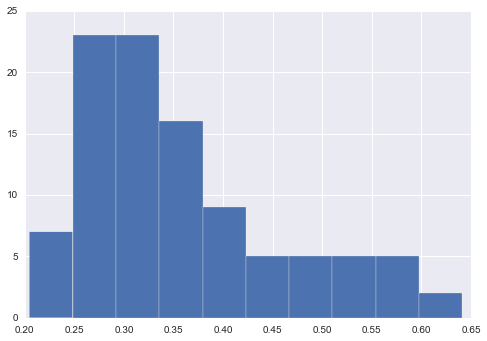

In [2]:
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from pymc import rbeta
import matplotlib.pyplot as plt

n = 100
y = 0.75 * rbeta(1, 5, n) + 0.25 * rbeta(20, 2, n)

counts, bins, patches = plt.hist(y, bins=10)

In [3]:
counts

array([  7.,  23.,  23.,  16.,   9.,   5.,   5.,   5.,   5.,   2.])

We can use these bin counts to calculate the expected value of the Dirichlet posterior:

In [4]:
from pymc import dirichlet_expval
import numpy as np

p = dirichlet_expval(1+counts)
p = np.append(p, 1.-p.sum())
y_exp = n*p

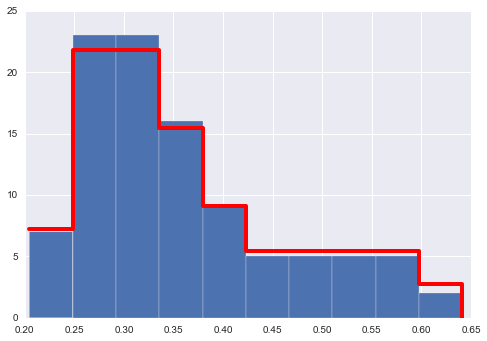

In [5]:
plt.hist(y, bins=10)
plt.step(bins, y_exp, color='red', where='post', linewidth=4)

While this does a good job of density approximation, the estimates are clearly sensitive to the choice of bins (both number and location):

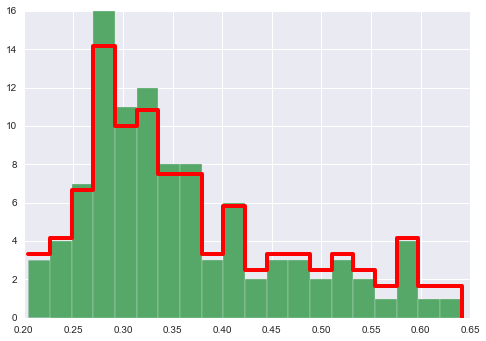

In [6]:
counts, bins, patches = plt.hist(y, bins=20)

p = dirichlet_expval(1+counts) 
y_exp = n*np.append(p, 1.-p.sum())

plt.hist(y, bins=20)
plt.step(bins, y_exp, color='red', where='post', linewidth=4)

So, while this is a simple, straightforward approach to flexible density estimation, we would prefer not to have to specify bins *a priori*. Happily, with a little work, we can generalize the Dirichlet to make it more flexible

## Dirichlet Process Prior

Consider a sample space $\Omega$ that we may partition into $k$ non-overlapping subsets $\{B_1,\ldots,B_k\} \in \mathcal{B}$. We can assign a probability measure $P$ to this partition:

$$P(B_1),\ldots,P(B_k) = \int_{B_1} f(x) dx, \ldots, \int_{B_k} f(x) dx$$

A Dirichlet distribition would be a natural conjugate prior on these partition (bin) probabilities:

$$P(B_1),\ldots,P(B_k) \sim \text{Dirichlet}(a P_0(B_1), \ldots, a P_0(B_k))$$

where $P_0$ is a base probability measure and $a > 0$ can be interpreted as prior sample size, which essentially controls the amount of prior shrinkage.

However, we want our model to be insensitive to the choice of partition and to the number of bins. The important implication of specifying this prior is that although probabilities are assigned to each bin, it does not prescribe how that probability mass is distributed across any particular bin.

If we combine (or split) the elements of a Dirichlet distribution, it results in another Dirichlet:

$$\begin{aligned}
\pi_1, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1, \ldots, \alpha_k) \\
\Rightarrow \pi_1 + \pi_2, \pi_3, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1 + \alpha_2, \alpha_3, \ldots, \alpha_k)
\end{aligned}$$

or generally, for partition $\{B_1,\ldots,B_k\} \in \mathcal{B}$:

$$\sum_{h \in B_1} \pi_h, \ldots, \sum_{h \in B_k} \pi_h \sim \text{Dirichlet}(\sum_{h \in B_1} \alpha_h, \ldots, \sum_{h \in B_k} \alpha_h)$$

Similarly, for $\beta_1 + \beta_2 = 1$,

$$\begin{aligned}
\pi_1, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1, \ldots, \alpha_k) \\
\tau_1, \tau_2 &\sim \text{Dirichlet}(\alpha_1 \beta_1, \alpha_1 \beta_2) \\
\Rightarrow \pi_1\tau_1 + \pi_1\tau_2, \pi_2, \ldots, \pi_k &\sim \text{Dirichlet}(\alpha_1\beta_1, \alpha_1\beta_2, \alpha_2, \alpha_3, \ldots, \alpha_k)
\end{aligned}$$

Just as the Gaussian process is a distribution over functions, a **Dirichlet process** is a distribution over distributions (or, measure over measures). 

$$P \sim DP(\alpha P_0)$$

It is centered upon the baseline probability measure $P_0$, with $\alpha$ specifying the certainty in this baseline (*i.e.* inverse variance).

The expectation of a DPP is:

$$E[P(B)] = P_0(B)$$

in other words, centered on the baseline measure, and the variance is:

$$\text{Var}(P(B)) = \frac{P_0(B)(1-P_0(B))}{1 + \alpha}$$

It is essentially an *infinitely decimated* Dirichlet distribution. The marginal probability assigned to any subset $B$ is beta distributed:

$$P(B) \sim \text{Beta}(\alpha P_0(B), \alpha (1-P_0(B)))$$

## Stick-breaking Process

The specification of the DP above may not be intuitive, in terms of what a DP realization looks like. A generative approach for allocating observations to groups is the stick-breaking process, which involves breaking the support of a particular variable into $k$ disjoint segments. Here, we start with a "stick" of unit length. To "break" the stick, we generate random points along the stick via the following algorithm:

1. generate a random variable $\beta_1 \sim Beta(1, \alpha_0)$
2. use this random variable (which is on the unit interval) to define a break point on the stick
3. iterate $k-1$ times:
    - generate $\beta_i \sim Beta(1, \alpha_0)$
    - identify next break point at $\pi_i = \beta_i \prod_{j=1}^{i-1} (1-\beta_j)$ (which is on the part of the stick that remains after the previous break)

This results in the creation of $k$ "pieces". Associated with each piece is a probability that is proportional to its length; these $k$ probabilities will have a Dirichlet distribution -- thus, the DP is a distribution over distributions. 

This process defines an **exchangeable** distribution on partitions of the stick; though there is an order to the generation of the segments, the distribution is independent of order.

Notice that $k$ can be infinite, making $G$ an infinite mixture.

One way to implement a stick-breaking constructive process in Python is as follows:

In [7]:
from numpy.random import beta

def stick_breaking(alpha, k):
    betas = beta(1, alpha, k)
    remaining_pieces = np.append(1, np.cumprod(1 - betas[:-1]))
    p = betas * remaining_pieces
    return p/p.sum()

For example, let's construct a DP with a baseline distribution that is standard normal:

$$P_0 = N(0,1)$$

We take a draw of $k$ values from the baseline distribution:

$$ \theta_1, \theta_2, \ldots \theta_k \sim P_0 $$

In [8]:
k = 25
alpha = 7
theta = np.random.normal(0, 1, k)

then, using a stick breaking process, we can obtain a set of draws $\beta_1, \beta_2, \ldots$ from a $\text{Beta}(1,\alpha)$. These are used to assign probabilities to the $\theta_i$ values. As we established above, the probability of each $\theta_i$ is calculated via:

$$ \pi_i = \beta_i \prod_{j=1}^{i-1} (1 - \beta_j) $$

In [9]:
p = stick_breaking(alpha, k)

These probabilities correspond to the set of draws from the baseline distribution, where each of the latter are point masses of probability. So, the DP density function is:

$$ P(x) = \sum_{i=1}^{n} \pi_i I(x=\beta_i) $$

where $I$ is the indicator function.

In [10]:
x = np.random.multinomial(k, p)
dp = theta[x]
dp

array([ 0.64955365, -0.2165807 ,  0.0072041 , -0.2165807 , -0.91331666,
       -0.91331666,  0.64955365, -0.2165807 , -0.2165807 , -0.2165807 ,
       -0.2165807 , -0.2165807 ,  0.64955365, -0.2165807 , -0.91331666,
       -0.91331666, -0.91331666, -0.91331666, -0.2165807 , -0.99722722,
       -0.91331666, -0.91331666, -0.2165807 , -0.91331666, -0.91331666])

<Container object of 5 artists>

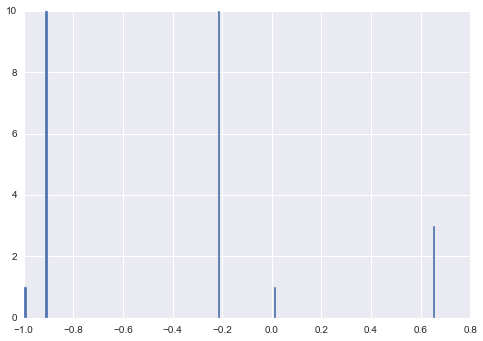

In [11]:
x = set(dp)
f = [(dp==i).sum() for i in x]
plt.bar(x, f, width=0.01)

So, you can see that the Dirichlet process is discrete, despite the fact that its values may be non-integer. This can be generalized to a mixture of continuous distributions, which is called a DP mixture.

Here are several realizations with $k=20$ and $\alpha=0.5$. So, there are 20 bars (sorted), and the height of the bar represents that group's probability.

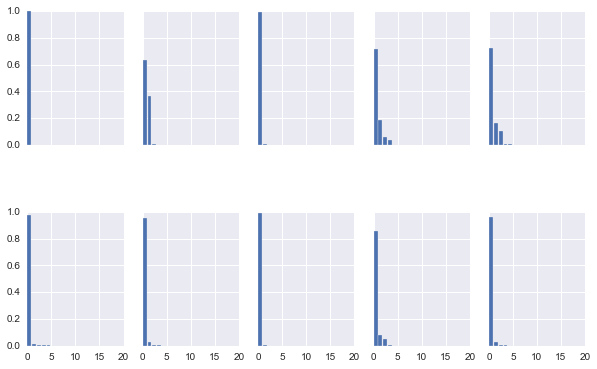

In [12]:
k = 20
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    ax.bar(np.arange(k), np.sort(stick_breaking(alpha=0.5, k=k))[::-1])

For $\alpha=5$:

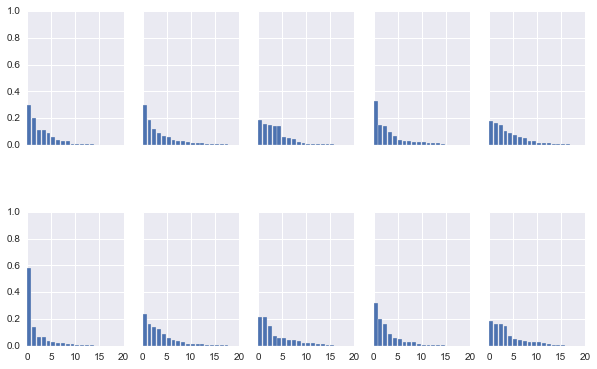

In [13]:
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    ax.bar(np.arange(k), np.sort(stick_breaking(alpha=5, k=k))[::-1])
    ax.set_ylim(0,1)

For $\alpha=25$:

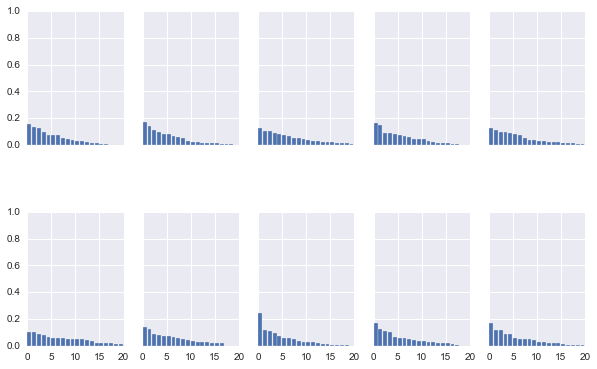

In [14]:
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    ax.bar(np.arange(k), np.sort(stick_breaking(alpha=25, k=k))[::-1])
    ax.set_ylim(0,1)

As $\alpha_0$ increases, the weights (stick sizes) are more even across the samples.

We can use the stick-breaking process to induce $P \sim DP(\alpha P_0)$ for some $P_0$.

$$P(\cdot) = \sum_{h=1}^k \pi_h \delta_{\theta_h}(\cdot)$$

Where the $\pi_h$ are geenrated by stick-breaking, $\delta_{\theta}$ is a degenerate distribution with the entire probability mass at $\theta$, which in turn, are generated by $P_0$; here, we will use a standard normal.

In [15]:
from numpy.random import choice

def dirichlet_process(p, n, P0=np.random.randn):
    theta = P0(len(p))
    return np.random.choice(theta, size=n, p=p)

$\alpha=1$

In [16]:
p = stick_breaking(alpha=0.5, k=1000)

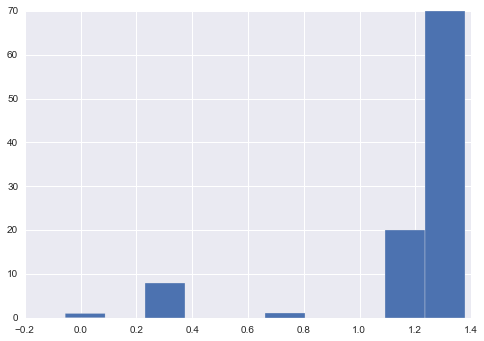

In [17]:
_ = plt.hist(dirichlet_process(p, 100))

$\alpha=5$

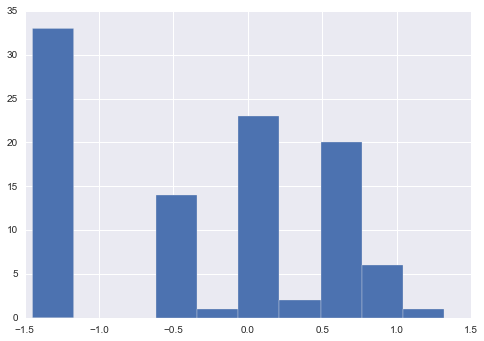

In [18]:
p = stick_breaking(alpha=5, k=1000)
_ = plt.hist(dirichlet_process(p, 100))

$\alpha=25$

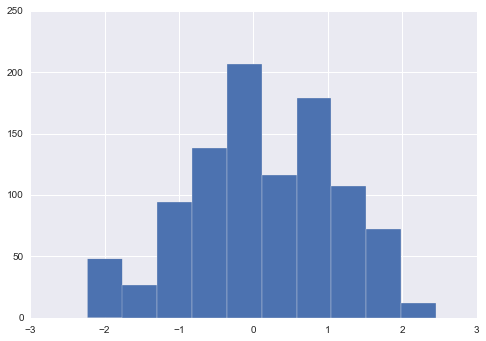

In [19]:
p = stick_breaking(alpha=25, k=10000)
_ = plt.hist(dirichlet_process(p, 1000))

Notice that, while the particular values of the DP realizations are continuous, the distribution is discrete. But, as $\alpha \rightarrow \infty$, the likelihood of indexing the same $\theta_h$ more than once goes to zero, and one is essentially drawing from $P_0$.

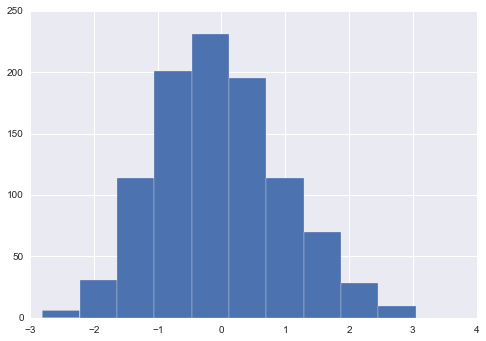

In [20]:
p = stick_breaking(alpha=1000, k=10000)
_ = plt.hist(dirichlet_process(p, 1000))

So, while the DP is of limited use as a direct prior of a data distribution, it is extremely useful as a prior for an unknown mixture.

If we generalize the above approach such that the DP is used as the mixture measure for some kernel $\mathcal{K}(y|\theta)$, then we can define the mixture model:

$$f(y) = \sum_{h=1}^{\infty} \pi_h \mathcal{K}(y|\theta_h)$$

This is no different than other mixture models we have seen, except that the number of components is infinite. In practice, almost all the components are empty when we consider using it to model a finite dataset, but the model has the capacity to increase the number of mixture components as data are added.

This model can be specified hierarchically by:

$$\begin{aligned}
P &\sim DP(\alpha P_0) \\
\theta_i &\sim P \\
y_i &\sim \mathcal{K}(y|\theta_i)
\end{aligned}$$

The computational hurdle is in how to characterize the mixture when we cannot generate infinite mixture components. For this, we will use another generative model metaphor, the *Chinese restaurant process*.

## Chinese Restaurant Process

Consider a hypothetical Chinese restaurant with an *infinite* number of tables. 

![chinese restaurant](http://farm3.staticflickr.com/2153/2239018463_5f3e302c17_z.jpg)

* The first customer entering the restaurant sits at the first empty table.

* The next customer either joins the first customer with some probability $1/(1 + \alpha), \alpha>0$, or selects an empty table with probability $\alpha/(1 + \alpha)$.

* Subsequent customers either join an occupied table with a probability proportional to the number of customers already at each table, or selects an empty table.

This process is formalized as:

$$p(\theta_n | \theta_1, \ldots, \theta_{n-1}) \sim \left(\frac{\alpha}{\alpha + n - 1}\right) P_0(\theta_n) + \sum_{j=1}^{n-1} \left(\frac{1}{\alpha + n - 1}\right)\delta_{\theta_j}$$

This is called the *Pólya urn model*.

Of course, the analogy here is that the customers are data and the tables are clusters. Hence, the process describes a prior on the partitioning of the data into clusters.

In [21]:
def chinese_restaurant_process(n, alpha):
    
    if n < 1:
        return None
    
    table_assignments = np.empty(n)
    next_table = 0
    
    for c in range(n):

        if np.random.random() < (1. * alpha / (alpha + c)):
            
            # Sit at new table
            table_assignments[c] = next_table
            next_table += 1
            
        else:
            
            # Calculate selection probabilities as function of population
            probs = [(table_assignments[:c]==i).sum()/float(c) 
                     for i in range(next_table)]
            # Randomly assign to existing table
            table_assignments[c] = choice(range(next_table), p=probs)
        
    return table_assignments

Let's try a few runs. First, with 10 customers:

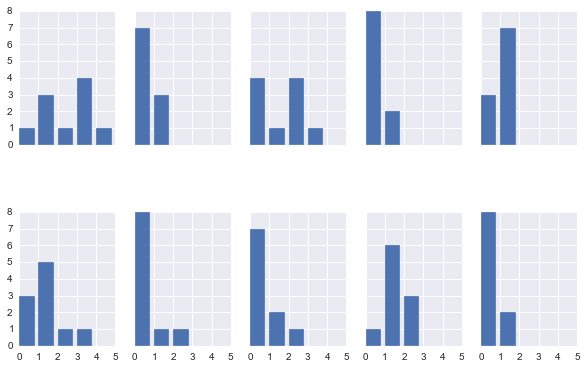

In [22]:
n = 10
alpha = 1

def plot_crp(table_nums, ax=None):
    x = list(range(int(table_nums.max()) + 1))
    f = [(table_nums==i).sum() for i in set(table_nums)]
    if ax is None: ax = plt
    ax.bar(x, f)
    
fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    plot_crp(chinese_restaurant_process(n, alpha), ax=ax)

Then 100:

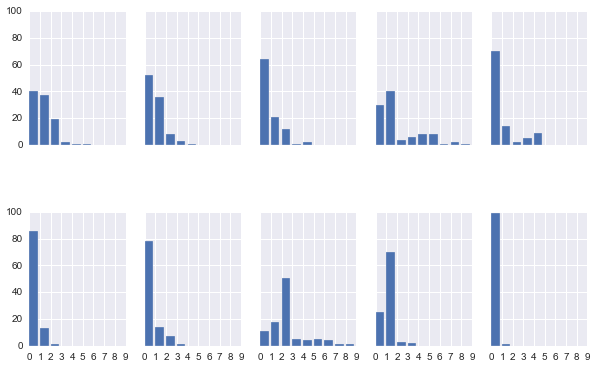

In [23]:
n = 100

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    plot_crp(chinese_restaurant_process(n, alpha), ax=ax)

And 500:

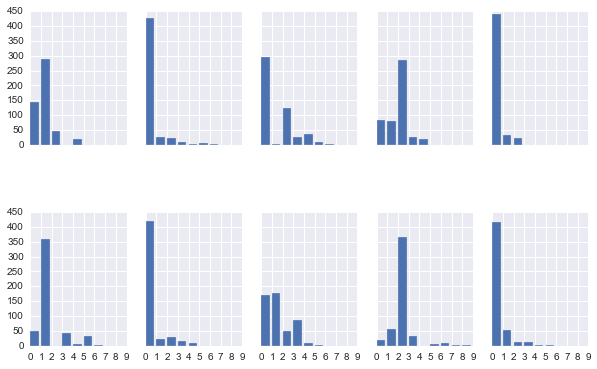

In [24]:
n = 500

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(10,6))
for ax in np.ravel(axes):
    plot_crp(chinese_restaurant_process(n, alpha), ax=ax)

Notice that the number of occupied tables increases with $n$ (and with $\alpha$). Hence, in the context of a prior on the number of clusters, the process is non-parametric (grows approximately as $\mathcal{O}(\log(n)$)).

If we examine the sample draws from either the Chinese restaurant process or the stick-breaking process above, it is apparent that each sample represents a realization from the same underlying process (when the parameter values are the same). We can use either of these generative processes to generate weights for the DP.

Alternately, we could use a CRP to generate groups (tables), where each element from the same group would be assigned the same value sampled from $P_0$.

## Non-parametric Random Effects in Hierarchical Models

A standard parametric assumption in linear and hierarchical modeling is that errors or random effects are Gaussian. For example,

$$y_i = X_i \beta + \epsilon_i$$

$$\epsilon_i \sim f$$

where the error distribution is typically specified as $f = N(0,\sigma^2)$. In robust regression, this restriction is partially relaxed by assuming a Student's $t$ model, which downweights the influence of outliers, but the shape is still restrictive.

A more flexible alternative is to use an infinite mixture of normals for $f$, using a Dirichlet process:

$$\begin{aligned}
P &\sim DP(\alpha P_0) \\
\tau_i &\sim P \\
\epsilon_i &\sim N(0, \tau_i^{-1})
\end{aligned}$$

If we specify $P_0$ as $\text{Gamma}(\nu/2, \nu/2)$, the corresponding DP is centered on a $t$ distribution, which still models the error distribution as unimodal and zero mean. 

In the context of hierarchical models, we may want to model individual variation in some parameter, such as a subject-varying mean:

$$\begin{aligned}y_{ij} &= \mu_i + \epsilon_{ij} \\
\mu_i &\sim f \\
\epsilon_{ij} &\sim g
\end{aligned}$$

where $y_{i}$ is a vector of $j = 1,\ldots,n_i$ repreated measurements for individual $i$. In the majority of applications, both $f$ and $g$ are specified with normal distributions.

If we want a less-restrictive form for this random effect, we can place a DP prior on the $\mu_{i}$.

$$\mu_i \sim P$$

$$P \sim DP(\alpha P_0)$$

This approach induces a latent class model on the $\mu_i$, where there are an unknown number of clusters:

$$\mu_i = \mu_{S_i}$$

$$Pr(S_i = h) = \pi_h$$

where $\pi_h$ is the probability of allocation to class $h = 1, \ldots, \infty$. This will result in a posterior distribution of cluster allocations (and hence, for the $\mu_i$), since the clustering is probabilistic.

Since we do not observe the $\mu_i$ directly, it relies on information in the repeated measurements for each individual, so this model will not be useful for $n_i$ = 1.

## Example: Estimating household radon levels

As an example of implementing Dirichlet processes for random effects, we will use the radon measurement and remediation example from [Gelman and Hill (2006)](http://amzn.to/gFfJbs). This problem uses measurements of [radon](http://en.wikipedia.org/wiki/Radon) (a carcinogenic, radioactive gas) from households in 85 counties in Minnesota to estimate the distribution of the substance across the state. This dataset has a natural hierarchical structure, with individual measurements nested within households, and households in turn nested within counties. Here, we are certainly interested in modeling the variation in counties, but do not have covariates measured at that level. Since we are more interested in the variation among counties, rather than the particular levels for each, a random effects model is appropriate. 

In the original example from Gelman and Hill, measurements are modeled as being normally distributed, with a mean that is a hierarchical function of both a county-level random effect and a fixed effect that accounted for whether houses had a basement (this is thought to increase radon levels).

$$ y_i \sim N(\alpha_{j[i]} + \beta x_i, \sigma_y^2) $$
	
So, in essence, each county has its own intercept, but shares a slope among all counties. This can easily be generalized to both random slopes and intercepts, but let's keep things simple, in order to focus on implementing a single random effect.

The constraint that is applied to the intercepts in Gelman and Hill's original model is that they have a common distribution (Gaussian) that describes how they vary from the state-wide mean.

$$ \alpha_j \sim N(\mu_{\alpha}, \sigma_{\alpha}^2) $$
	
This comprises a so-called "partial pooling" model, whereby counties are neither constrained to have identical means (full pooling) nor are assumed to have completely independent means (no pooling); in most applications, the truth is somewhere between these two extremes. Though this is a very flexible approach to accounting for county-level variance, one might be worried about imposing such a restrictive (thin-tailed) distribution like the normal on this variance. If there are counties that have extremely low or high levels (for whatever reason), this model will fit poorly. To allay such worries, we can hedge our bets by selecting a more forgiving functional form, such as [Student's t](http://en.wikipedia.org/wiki/Student's_t-distribution) or [Cauchy](http://en.wikipedia.org/wiki/Cauchy_distribution), but these still impose parametric restrictions (*e.g.* symmetry about the mean) that we may be uncomfortable making. So, in the interest of even greater flexibility, we will replace the normal county random effect with a non-parametric alternative, using a Dirichlet process.

First, let's import the data:

In [25]:
import pandas as pd

# Import radon data
srrs2 = pd.read_csv('../data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN']

counties = srrs_mn.county.values
y = srrs_mn.activity.values
x = srrs_mn.floor.values

## gelman adjustment for log
y[y==0]=.1
y = np.log(y)

## groupings
def createCountyIndex(counties):
    counties_uniq = sorted(set(counties))
    counties_dict = dict()
    for i, v in enumerate(counties_uniq):
        counties_dict[v] = i
    ans = np.empty(len(counties),dtype='int')
    for i in range(0,len(counties)):
        ans[i] = counties_dict[counties[i]]
    return ans

index_c = createCountyIndex(counties)

One of the difficulties in implementing DP computationally is how to handle an infinite mixture. The easiest way to tackle this is by using a truncated Dirichlet process to approximate the full process. This can be done by choosing a size $N$ that is sufficiently large that it will exceed the number of point masses required. By doing this, we are assuming

$$ \sum_{i=1}^{\infty} p_i I(x=\theta_i) \approx \sum_{i=1}^{N} p_i I(x=\theta_i) $$

[Ohlssen et al. 2007](http://onlinelibrary.wiley.com/doi/10.1002/sim.2666/abstract) provide a rule of thumb for choosing $N$ such that the sum of the first $k-1$ point masses is greater than 0.99:

$$ N \approx 5\alpha + 2 $$

To be conservative, we will choose an even larger value (100), which we will call `N_dp`.

In [26]:
N_dp = 100

We first must specify the baseline distribution and the concentration parameter. As we have no prior information to inform a choice for $\alpha$, we will specify a uniform prior for it, with reasonable bounds:

In [27]:
import pymc as pm

alpha = pm.Uniform('alpha', lower=0.5, upper=10)

Though the upper bound may seem small for a prior that purports to be uninformative, recall that for large values of $\alpha$, the DP will converge to the baseline distribution, suggesting that a continuous distribution would be more appropriate.

Since we are extending a normal random effects model, I will choose a Student's $t$ baseline distribution, with vague hyperpriors:

In [28]:
nu = len(set(counties)) - 1
tau_0 = pm.Gamma('tau_0', nu/2., nu/2.)
mu_0 = pm.Normal('mu_0', mu=0, tau=0.01, value=0)

theta = pm.Normal('theta', mu=mu_0, tau=tau_0, size=N_dp)

Notice that I have specified a uniform prior on the standard deviation, rather than the more common [gamma](http://en.wikipedia.org/wiki/Gamma_distribution)-distributed precision; for hierarchical models this is [good practice](http://ba.stat.cmu.edu/journal/2006/vol01/issue03/gelman.pdf). So, now we that we have `N_dp` point masses, all that remains is to generate corresponding probabilities. Following the recipe above:

In [29]:
v = pm.Beta('v', alpha=1, beta=alpha, size=N_dp)

@pm.deterministic
def p(v=v):
    """ Calculate Dirichlet probabilities """

    # Probabilities from betas
    value = [u*np.prod(1-v[:i]) for i,u in enumerate(v)]
    # Enforce sum to unity constraint
    value /= np.sum(value)

    return value

# Expected value of random effect
E_dp = pm.Lambda('E_dp', lambda p=p, theta=theta: np.dot(p, theta))

This is where you really appreciate Python's [list comprehension](http://docs.python.org/tutorial/datastructures.html#list-comprehensions) idiom. In fact, were it not for the fact that we wanted to ensure that the array of probabilities sums to one, `p` could have been specified in a single line.

The final step involves using the Dirichlet probabilities to generate indices to the appropriate point masses. This is realized using a categorical mass function:

In [30]:
z = pm.Categorical('z', p, size=len(set(counties)))

These indices, in turn, are used to index the random effects, which are used as random intercepts for the model.

In [31]:
# Index random effect
a = pm.Lambda('a', lambda z=z, theta=theta: theta[z])

b = pm.Normal('b', mu=0., tau=0.0001)

y_hat = pm.Lambda('y_hat', lambda a=a, b=b: a[index_c] + b*x)

In [32]:
sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
tau_y = sigma_y**-2

y_like = pm.Normal('y_like', mu=y_hat, tau=tau_y, value=y, observed=True)

In [33]:
M = pm.MCMC([a, b, sigma_y, y_like, z, v, mu_0, tau_0, theta, alpha, E_dp])

In [34]:
M.sample(20000, 10000)

 [-----------------100%-----------------] 20000 of 20000 complete in 18.0 sec

Substitution of the above code into Gelman and Hill's original model produces reasonable results. The expected value of $\\alpha$ is approximately 1.35, as shown by the posterior output below:

Plotting E_dp


/Users/fonnescj/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


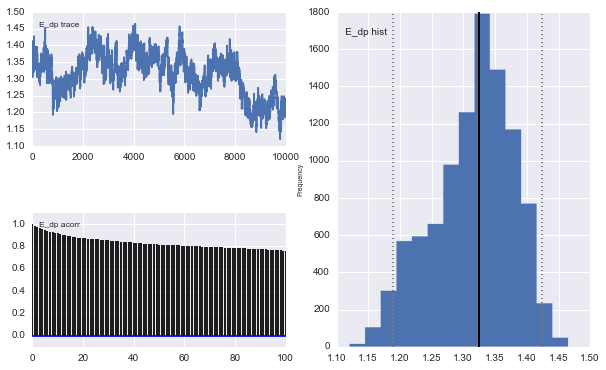

In [35]:
pm.Matplot.plot(E_dp)

Here is a random sample taken from the DP:


(array([  2.,   0.,   0.,   3.,   7.,   9.,   0.,  38.,   9.,  17.]),
 array([ 0.09360919,  0.27629225,  0.45897531,  0.64165837,  0.82434143,
         1.00702449,  1.18970755,  1.37239062,  1.55507368,  1.73775674,
         1.9204398 ]),
 <a list of 10 Patch objects>)

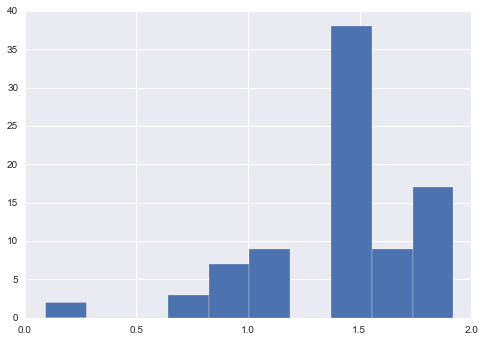

In [36]:
plt.hist(a.trace()[105])

But is the model better? We can compare this model to a conventional normal random effect.

In [37]:
def radon_normal():
    
    # Hyperpriors
    mu_0 = pm.Normal('mu_0', mu=0, tau=0.01, value=0)
    sig_0 = pm.Uniform('sig_0', lower=0, upper=100, value=1)
    tau_0 = sig_0 ** -2
    
    # Original random effect on intercept
    a = pm.Normal('a', mu=mu_0, tau=tau_0, value=np.zeros(len(set(counties))))
    
    b = pm.Normal('b', mu=0., tau=0.0001)
    
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    tau_y = pm.Lambda('tau_y', lambda s=sigma_y: s**-2)
    
    # Model
    @pm.deterministic
    def y_hat(a=a,b=b):
           return a[index_c] + b*x
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, tau=tau_y, value=y, observed=True)

    return locals()

In [38]:
M0 = pm.MCMC(radon_normal())

In [39]:
M0.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.4 sec

One metric for model comparison is the [deviance information criterion](http://en.wikipedia.org/wiki/Deviance_information_criterion) (DIC), which appears to strongly favor the DP random effect (smaller values are better):

In [40]:
M0.DIC

3312.4335578240334

In [41]:
M.DIC

2069.1980309634455

## Exercise: Random effects meta-analysis

Recall the beta-blockers meta-analysis from Homework 2, where Carlin (1992) considers a Bayesian approach to meta-analysis, and includes examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. 

In one possible random effects model we assume the true effect (on a log-odds scale) $d_i$ in a trial $i$ is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu \\
\text{logit}\left(p^T_i\right) &= \mu + \delta_i \\
\delta_i &\sim f
\end{aligned}$$

Instead of assuming a Gaussian random effect $f$, experiment with Dirichlet process priors, and check whether it improves the resulting model.

In [42]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [ ]:
# Write your answer here

## References

1. Dunson D. Bayesian nonparametric hierarchical modeling. Biometrical Journal. January 2009.
2. Teh, Y. W., & Jordan, M. I. (2010). [Hierarchical Bayesian nonparametric models with applications](http://www.cs.berkeley.edu/~jordan/papers/teh-jordan-bnp.pdf). Bayesian nonparametrics, 158–207.